# Beer Reviews Test
 ***Daniel Guyatt, October 2021***

## Introduction

The following is an analysis performed on a dataset of 1.5m beer reivews from www.beeradvocate.com which seeks to answer four questions as posed by TCB Analytics as part of their hiring process to test for data skills.

The data has been sourced from Kaggle: https://www.kaggle.com/rdoume/beerreviews

The questions to be answered are as follows:

1. *Which brewery produces the strongest beers by ABV%?*
2. *If you had to pick 3 beers to recommend using only this data, which would you pick?*
3. *Which of the factors (aroma, taste, appearance, palate) are most important in determining the overall quality of the beer?*
4. *Lastly, if I typically enjoy a beer due to its aroma and appearance, which beer style should I try?*

---


## Set Up 

The first step is to get an initial view of the data so at to be able to create a plan of action for the analysis.

### Import packages


In [1]:
# import some useful packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import statsmodels.api as sm
import datetime as dt
import requests
import os

from collections import Counter
from scipy import stats

%matplotlib inline

sns.set(rc={'axes.facecolor':'linen'})

### Load Data

In [2]:
#  connect to kaggle api to downoad data
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [3]:
# search for the dataset to confrim reference
api.datasets_list(search='beerreviews')

[{'id': 1705857,
  'ref': 'ruthgn/beer-profile-and-ratings-data-set',
  'subtitle': 'Beer Dataset with Tasting Profiles and Consumer Ratings',
  'creatorName': 'ruthgn',
  'creatorUrl': 'ruthgn',
  'totalBytes': 504214,
  'url': 'https://www.kaggle.com/ruthgn/beer-profile-and-ratings-data-set',
  'lastUpdated': '2021-11-18T20:06:09.85Z',
  'downloadCount': 428,
  'isPrivate': False,
  'isReviewed': False,
  'isFeatured': False,
  'licenseName': 'Attribution 4.0 International (CC BY 4.0)',
  'description': None,
  'ownerName': 'ruthgn',
  'ownerRef': 'ruthgn',
  'kernelCount': 3,
  'title': 'Beer Profile and Ratings Data Set',
  'topicCount': 0,
  'viewCount': 3374,
  'voteCount': 23,
  'currentVersionNumber': 8,
  'usabilityRating': 1.0,
  'tags': [{'ref': 'nlp',
    'name': 'nlp',
    'description': 'Natural Language Processing gives a computer program the ability to extract meaning human language. Applications include sentiment analysis, translation, and speech recognition.',
    'fu

In [4]:
# download data and find name
api.dataset_download_files('rdoume/beerreviews', unzip=True)
os.listdir()


['Beer Reviews Notebook.ipynb',
 '.DS_Store',
 'beer_reviews.csv',
 'README.md',
 '.ipynb_checkpoints',
 '.git']

In [5]:
# read into df and see the first few rows
df = pd.read_csv('beer_reviews.csv')

df_beer = df.copy()
df_beer.head()

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883


## Cleaning & EDA

In [6]:
df_beer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586614 entries, 0 to 1586613
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   brewery_id          1586614 non-null  int64  
 1   brewery_name        1586599 non-null  object 
 2   review_time         1586614 non-null  int64  
 3   review_overall      1586614 non-null  float64
 4   review_aroma        1586614 non-null  float64
 5   review_appearance   1586614 non-null  float64
 6   review_profilename  1586266 non-null  object 
 7   beer_style          1586614 non-null  object 
 8   review_palate       1586614 non-null  float64
 9   review_taste        1586614 non-null  float64
 10  beer_name           1586614 non-null  object 
 11  beer_abv            1518829 non-null  float64
 12  beer_beerid         1586614 non-null  int64  
dtypes: float64(6), int64(3), object(4)
memory usage: 157.4+ MB


In [7]:
df_beer.describe()

,brewery_id,review_time,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv,beer_beerid
count,1.586614e+06,1.586614e+06,1.586614e+06,1.586614e+06,1.586614e+06,1.586614e+06,1.586614e+06,1.518829e+06,1.586614e+06
mean,3.130099e+03,1.224089e+09,3.815581e+00,3.735636e+00,3.841642e+00,3.743701e+00,3.792860e+00,7.042387e+00,2.171279e+04
std,5.578104e+03,7.654427e+07,7.206219e-01,6.976167e-01,6.160928e-01,6.822184e-01,7.319696e-01,2.322526e+00,2.181834e+04
min,1.000000e+00,8.406720e+08,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e-02,3.000000e+00
25%,1.430000e+02,1.173224e+09,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,5.200000e+00,1.717000e+03
50%,4.290000e+02,1.239203e+09,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,6.500000e+00,1.390600e+04
75%,2.372000e+03,1.288568e+09,4.500000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.500000e+00,8.500000e+00,3.944100e+04
max,2.800300e+04,1.326285e+09,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.770000e+01,7.731700e+04


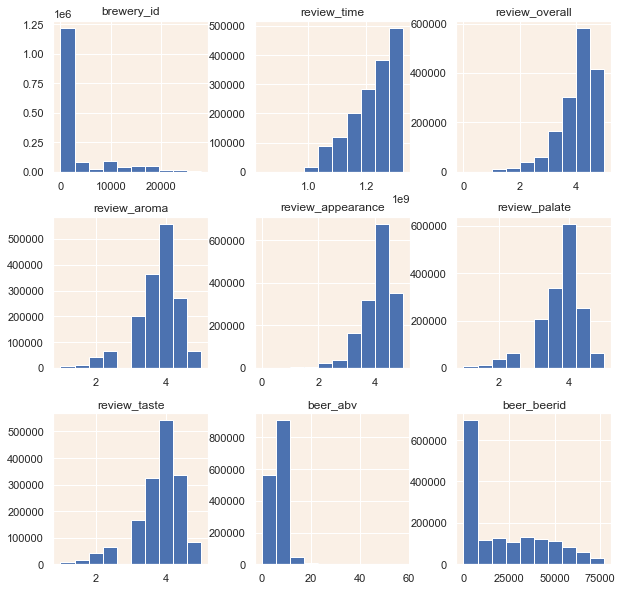

In [8]:
df_beer.hist(figsize=(10,10))
plt.show()

In [9]:
len(df_beer['beer_beerid'].unique())

66055

It could probably have been assumed from the outset but this confirms that unique beers have been reviewed multiple times by different users; thought needs to go into the aggregation method.

In [10]:
print(sorted(df_beer['review_overall'].unique()))
print(sorted(df_beer['review_aroma'].unique()))
print(sorted(df_beer['review_appearance'].unique()))
print(sorted(df_beer['review_palate'].unique()))
print(sorted(df_beer['review_taste'].unique()))

[0.0, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
[0.0, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


Strictly speaking, these variables are on an ordinal scale and care should be taken when considering measurements of central tendancy (which will be necessary later on) this will be discussed in more detail at the end of this section.

In [11]:
sorted(df_beer['beer_style'].unique())

['Altbier',
 'American Adjunct Lager',
 'American Amber / Red Ale',
 'American Amber / Red Lager',
 'American Barleywine',
 'American Black Ale',
 'American Blonde Ale',
 'American Brown Ale',
 'American Dark Wheat Ale',
 'American Double / Imperial IPA',
 'American Double / Imperial Pilsner',
 'American Double / Imperial Stout',
 'American IPA',
 'American Malt Liquor',
 'American Pale Ale (APA)',
 'American Pale Lager',
 'American Pale Wheat Ale',
 'American Porter',
 'American Stout',
 'American Strong Ale',
 'American Wild Ale',
 'Baltic Porter',
 'Belgian Dark Ale',
 'Belgian IPA',
 'Belgian Pale Ale',
 'Belgian Strong Dark Ale',
 'Belgian Strong Pale Ale',
 'Berliner Weissbier',
 'Bière de Champagne / Bière Brut',
 'Bière de Garde',
 'Black & Tan',
 'Bock',
 'Braggot',
 'California Common / Steam Beer',
 'Chile Beer',
 'Cream Ale',
 'Czech Pilsener',
 'Doppelbock',
 'Dortmunder / Export Lager',
 'Dubbel',
 'Dunkelweizen',
 'Eisbock',
 'English Barleywine',
 'English Bitter',
 'En

In [12]:
df_beer.isna().sum()

brewery_id                0
brewery_name             15
review_time               0
review_overall            0
review_aroma              0
review_appearance         0
review_profilename      348
beer_style                0
review_palate             0
review_taste              0
beer_name                 0
beer_abv              67785
beer_beerid               0
dtype: int64

Some key findings:

- The numerical values of the reviews are ordinal variables taking values from 0 to 5 allowing 0.5 marks for each score, this dictates which statistical measures and methods are valid.
- Some individual beers have more than one review by different user profiles, it is important to aggregate review scores when considering an individual beer and/or style.
- Beer styles are truly categorical ie they appear to have been selected from a finite list of options rather than typed in freehand by users so will not require any string transformations.
- There is a large number of observations (in absolute terms, not proportionally) which do not have an ABV entry, this may me be because these beers do not contain alcohol or it may be due to something else - some cleaning is required.
---

### A Note on Review Scores (Optional):

Strictly speaking the review scores are ordinal: they are ranks, encoded with numbers which have no inherent meaning - there is nothing to say that the difference between scores of 1-2 is the same as as the difference between scores 4-5. I would go as far as to say the scale is almost certainly _not_ linear due to the inevitable cognitive biases at play resulting from human reviewers, and indeed there are hints of this in the way the review score histograms are skewed. Furthermore we cannot say anything about the value of a score *across* users, ie a score of 4 for one user is by no means necessarily the same as a 4 for another user; they may have different value systems.

However this does not tell the whole story, I will also argue that these variables are not purely ordinal in the  sense that values *between ranks* have no meaning because they do - the 5 mark scale is arbitrary since the beeradvocate website clearly allows half (0.5) scores, so one could easily imagine that users might be able to score beers, say, 4.25 given the option or even yet smaller fractions given a sliding scale for example. Therefore continuous values *do* have meaning here so, at least when considering a single user in isolation, it would be valid to aggregate using mean value.

The core of the problem is to consider how aggregation of different user reviews should work, if all users reviewed all beers there would be no issue as the value base of each user would cancel out but this is not the case. Ultimately I would suggest that using a mean aggregation of reviews is still the best measure of central tendancy available, using the median sacrifices genuine resolution available in the data and differences in reviewers' value systems may have to be something to simply be aware of when making inferences. Great care must be taken, however, when comparing *magnitudes* of differences, particularly after aggregation: we *can* say aggregated values are higher than others but it is dangerous to assume *by how much* due to the non-linearity of the scale.

**TL;DR:**

Review scores will be treated as ordinal but the mean value will be used to measure central tendancy. Differences are valid but magnitudes of differences may not be.

---

### Cleaning

Types: Uniques, datetime in seconds,
Missing: counts, check for 0% then drop
Duplicates: user+beer_id

#### Data Types

<AxesSubplot:>

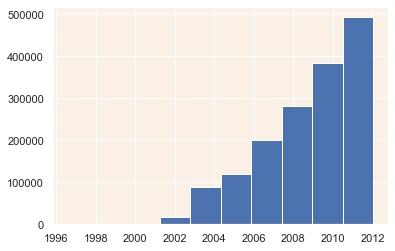

In [13]:
# First update the review_time variable to datetime
df_beer['review_time'] = pd.to_datetime(df_beer['review_time'],unit='s')
df_beer['review_time'].hist()

In [14]:
# update style variable
df_beer = df_beer.astype({'beer_style':'category'})

In [15]:
# Confirm
df_beer.dtypes

brewery_id                     int64
brewery_name                  object
review_time           datetime64[ns]
review_overall               float64
review_aroma                 float64
review_appearance            float64
review_profilename            object
beer_style                  category
review_palate                float64
review_taste                 float64
beer_name                     object
beer_abv                     float64
beer_beerid                    int64
dtype: object

In [16]:
df_beer.describe(include='category')

,beer_style
count,1586614
unique,104
top,American IPA
freq,117586


#### Missing Values

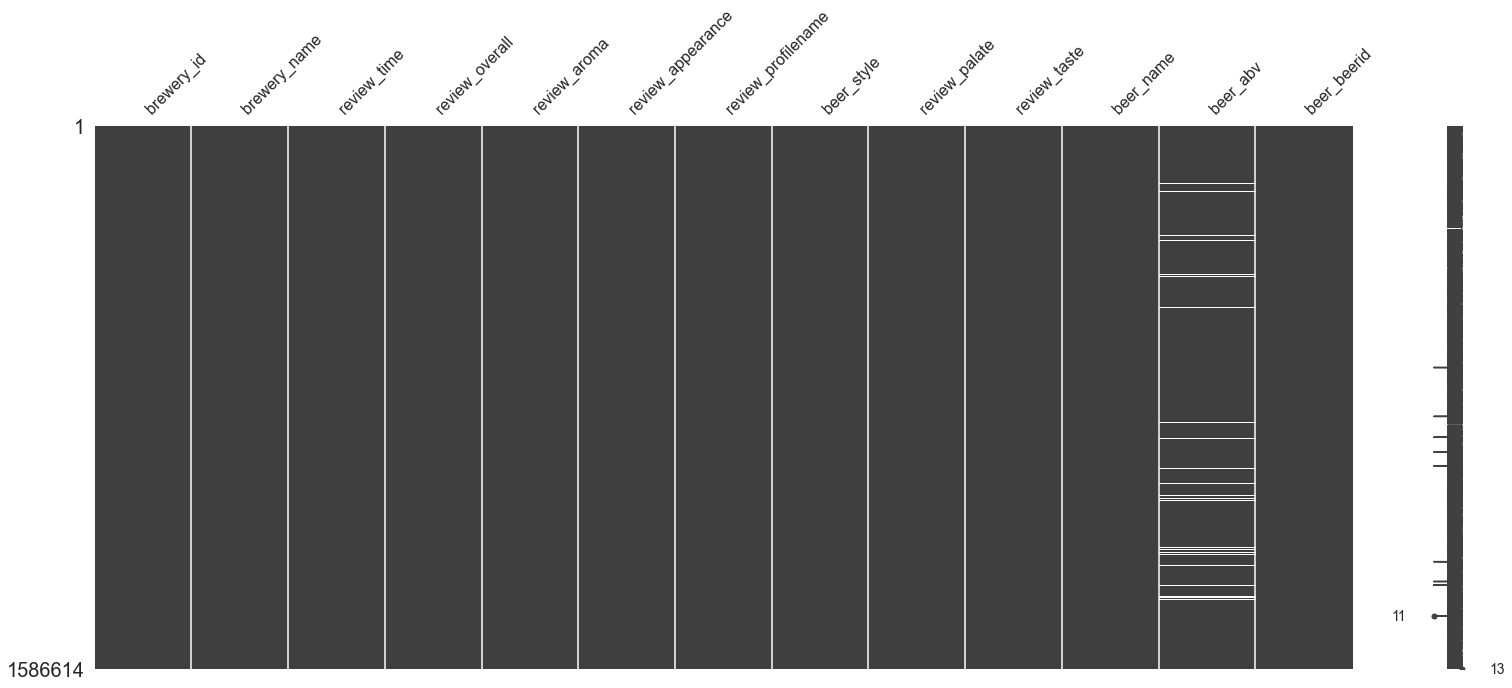

In [17]:
# first explore whether a beers ABV missing a value means it is a /
# non alcohoic beer or if it is missing for another reason

msno.matrix(df_beer)
plt.show()

In [18]:
missing = df_beer[df_beer['beer_abv'].isna()]
complete = df_beer[~df_beer['beer_abv'].isna()]

missing.describe()

,brewery_id,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv,beer_beerid
count,67785.000000,67785.000000,67785.000000,67785.000000,67785.000000,67785.000000,0.0,67785.000000
mean,4386.755742,3.629549,3.499757,3.646655,3.520122,3.542959,NaN,28633.903459
std,6162.525389,0.768298,0.705553,0.622949,0.706862,0.760566,NaN,21535.753359
min,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,3.000000
25%,565.000000,3.000000,3.000000,3.500000,3.000000,3.000000,NaN,8775.000000
50%,1341.000000,4.000000,3.500000,4.000000,3.500000,3.500000,NaN,25448.000000
75%,5408.000000,4.000000,4.000000,4.000000,4.000000,4.000000,NaN,44745.000000
max,27944.000000,5.000000,5.000000,5.000000,5.000000,5.000000,NaN,77317.000000


In [19]:
complete.describe()

,brewery_id,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv,beer_beerid
count,1.518829e+06,1.518829e+06,1.518829e+06,1.518829e+06,1.518829e+06,1.518829e+06,1.518829e+06,1.518829e+06
mean,3.074015e+03,3.823883e+00,3.746163e+00,3.850344e+00,3.753680e+00,3.804013e+00,7.042387e+00,2.140391e+04
std,5.543953e+03,7.172968e-01,6.953980e-01,6.143443e-01,6.793850e-01,7.286724e-01,2.322526e+00,2.177966e+04
min,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e-02,5.000000e+00
25%,1.410000e+02,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,5.200000e+00,1.654000e+03
50%,4.170000e+02,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,6.500000e+00,1.282700e+04
75%,2.298000e+03,4.500000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.500000e+00,8.500000e+00,3.923600e+04
max,2.800300e+04,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.770000e+01,7.731600e+04


In [20]:
# From the above tables and visualisation, there are no obvious underlying patterns behind the missing data.
# I will display some random samples a few times to explore further.

missing.sample(n=8).head(8)

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
295310,35,Boston Beer Company (Samuel Adams),2006-08-02 19:37:44,3.5,3.5,4.5,clickpush,American Porter,3.5,3.0,Brewer Patriot Collection - George Washington ...,NaN,30857
1214032,415,Sleeman Breweries Ltd.,2010-07-29 03:29:17,4.0,2.0,1.0,ChrisCage,American Blonde Ale,3.0,2.0,Original Hek Lager,NaN,21147
114075,3079,Ram International / Humperdinks Restaurant and...,2003-07-14 18:13:39,3.0,3.0,3.0,beerguy101,American IPA,3.0,3.0,Big Red Ale,NaN,7033
1098889,418,Left Hand Brewing Company,2011-03-21 00:50:37,3.5,3.5,3.5,dirtylou,American Barleywine,3.5,3.5,Oak Aged Widdershins (Brandy Barrel),NaN,48606
280443,3865,North End Tavern & Brewery,2003-07-27 15:02:37,3.5,3.5,3.0,deckjohn,American Pale Lager,3.0,3.5,Farson's Lager,NaN,11777
177235,1622,Titanic Brewing Company,2008-10-11 02:37:18,4.0,3.0,4.0,Patrick999,American Barleywine,3.5,4.5,Old Gnarley,NaN,45306
1406041,4399,New South Brewing Co.,2010-08-16 22:49:26,3.0,2.5,3.0,goblue3509,Witbier,3.0,2.5,White Ale,NaN,9613
256925,1033,Max Lager's American Grill & Brewery,2006-03-10 13:30:24,3.5,2.5,4.0,northyorksammy,Munich Dunkel Lager,3.0,3.0,Max Black,NaN,4152


In [21]:
# A quick search online of some of the listed beers confirms the entries are truly missing at random /
# insofar as they do not represent non-alcoholic beers and so must have been not entered by reviewers.
# I will delete these lines since there is not a substantial amount compared to the number of total entries.

df_beer = df_beer.dropna()
# this will also drop entries which have other columns with empties values also but these are insignificant

#### Duplicates

In [22]:
# I will consider a duplicate any review by the same user of the same beer, I want to keep the most recent review/
# to reflect the user's most recent opinion of the beer.

df_beer = df_beer.sort_values(by='review_time').drop_duplicates(subset = ['review_profilename','beer_beerid'], 
                                                      keep = 'last')

# confirm removal of duplicates
duplicates = df_beer.duplicated(subset=['review_profilename','beer_beerid'], keep=False)
df_beer[duplicates].head()


,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid


## Analysis

###  Plan
To discover which brewery produces the strongest beers I will aggregate the ABV values by beer_id to account for multiple users reviewing the same beer and then visualise some measures of centrality and spread of the ABVs after aggregating by brewery, I expect to be able to see in 2 dimensions which brewery has the highest average ABV beers with the highest consistency (smallest spread).

To recommend 3 beers I will find the 3 highest scoring beers in each of the 3 most common styles.

To determine which of the factors best determine the overall quality of the beer I will treat the review_overall data as a variable dependant on the rest of the review ratings and perform a feature selection analysis to essentially rank the review factors.

To recommend a beer style based on aroma and appearance I will agregate reveiws by beer and style, then highlight which styles score well on both factors.

---


### Questions

#### Question 1

**Which brewery produces the strongest beers by ABV%?**

To answer this question I need to aggregate user's reviews of beers so individual beers have only one entry and then aggregate further to have summary measures of beer strength by brewery.


In [23]:
df_grouped = df_beer.groupby(['brewery_name', 'beer_beerid']).mean().reset_index()

In [24]:
# Now each beer has its own line.
df_grouped.head(20)

,brewery_name,beer_beerid,brewery_id,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv
0,'t Hofbrouwerijke,28810,13160,3.722222,3.833333,3.666667,3.611111,3.777778,8.5
1,'t Hofbrouwerijke,28825,13160,4.500000,5.000000,4.500000,4.000000,3.500000,6.2
2,'t Hofbrouwerijke,33506,13160,3.812500,3.812500,4.000000,3.625000,3.593750,5.5
3,'t Hofbrouwerijke,33518,13160,3.357143,3.428571,3.714286,3.142857,3.428571,6.5
4,'t Hofbrouwerijke,49512,13160,3.000000,3.000000,4.000000,3.500000,3.500000,5.0
5,'t Hofbrouwerijke,64095,13160,3.750000,4.000000,3.750000,3.500000,3.750000,11.0
6,'t Hofbrouwerijke,69815,13160,4.000000,4.500000,3.500000,4.000000,4.000000,8.0
7,(512) Brewing Company,43534,17863,3.678571,3.750000,3.892857,3.785714,3.678571,5.5
8,(512) Brewing Company,43535,17863,4.259259,4.129630,4.009259,4.101852,4.185185,7.0
9,(512) Brewing Company,43536,17863,4.305556,3.972222,4.027778,3.888889,3.972222,5.5


In [25]:
df_grouped_agg = df_grouped.groupby('brewery_name').agg(['mean','std','count'])
df_grouped_agg.head(10)

beer_beerid                     brewery_id  \
                                        mean           std count       mean   
brewery_name                                                                  
't Hofbrouwerijke               44011.571429  17231.838467     7    13160.0   
(512) Brewing Company           55076.461538  10239.627659    13    17863.0   
10 Barrel Brewing Co.           60314.454545  13192.678040    11    16873.0   
1516 Brewing Company            29625.250000  21750.256403     4     4473.0   
16 Mile Brewing Company         61137.666667   7977.977079     6    20688.0   
1648 Brewing Company Ltd        40853.000000           NaN     1     8396.0   
1702 / The Address Brewing Co.  76453.000000           NaN     1    17783.0   
192 Brewing Company             62563.000000           NaN     1    22972.0   
2 Brothers Brewery              53907.333333   9563.989113     9    16847.0   
21st Amendment Brewery          43444.128205  23905.691493    78      735.0   

                                          review_overall                  \
                                std count           mean       std count   
brewery_name                                                               
't Hofbrouwerijke               0.0     7       3.734552  0.473435     7   
(512) Brewing Company           0.0    13       3.965673  0.221405    13   
10 Barrel Brewing Co.           0.0    11       3.807424  0.437862    11   
1516 Brewing Company            0.0     4       3.975000  0.332916     4   
16 Mile Brewing Company         0.0     6       3.547561  0.420705     6   
1648 Brewing Company Ltd        NaN     1       3.500000       NaN     1   
1702 / The Address Brewing Co.  NaN     1       4.000000       NaN     1   
192 Brewing Company             NaN     1       1.500000       NaN     1   
2 Brothers Brewery              0.0     9       3.628409  0.298013     9   
21st Amendment Brewery          0.0    78       3.616228  0.747611    78   

                               review_aroma  ... review_appearance  \
                                       mean  ...             count   
brewery_name                                 ...                     
't Hofbrouwerijke                  3.939201  ...                 7   
(512) Brewing Company              3.937002  ...                13   
10 Barrel Brewing Co.              3.704848  ...                11   
1516 Brewing Company               3.900000  ...                 4   
16 Mile Brewing Company            3.420833  ...                 6   
1648 Brewing Company Ltd           4.000000  ...                 1   
1702 / The Address Brewing Co.     4.500000  ...                 1   
192 Brewing Company                2.000000  ...                 1   
2 Brothers Brewery                 3.573906  ...                 9   
21st Amendment Brewery             3.520487  ...                78   

                               review_palate                 review_taste  \
                                        mean       std count         mean   
brewery_name                                                                
't Hofbrouwerijke                   3.625567  0.301428     7     3.650014   
(512) Brewing Company               3.892001  0.144005    13     3.983787   
10 Barrel Brewing Co.               3.781439  0.206419    11     3.703106   
1516 Brewing Company                3.662500  0.521816     4     3.987500   
16 Mile Brewing Company             3.564431  0.334344     6     3.456098   
1648 Brewing Company Ltd            3.500000       NaN     1     4.000000   
1702 / The Address Brewing Co.      4.000000       NaN     1     4.000000   
192 Brewing Company                 2.500000       NaN     1     2.000000   
2 Brothers Brewery                  3.566877  0.221788     9     3.540867   
21st Amendment Brewery              3.676147  0.480997    78     3.605349   

                                                beer_abv                  
                            

In [26]:
# some of the std values are showing as NaN  because they are from breweries producing only 1 beer/
# and so the std is not defined.
# I will set these values to -1 so we can plot them all but also highlight them on the chart

In [27]:
# Remove unnecessary columns
df_grouped_agg = df_grouped_agg['beer_abv']
df_grouped_agg.head(10)

,mean,std,count
brewery_name,,,
't Hofbrouwerijke,7.242857,2.080751,7
(512) Brewing Company,7.238462,1.286169,13
10 Barrel Brewing Co.,6.109091,1.612733,11
1516 Brewing Company,5.650000,0.994987,4
16 Mile Brewing Company,5.716667,0.844788,6
1648 Brewing Company Ltd,3.700000,NaN,1
1702 / The Address Brewing Co.,6.800000,NaN,1
192 Brewing Company,6.000000,NaN,1
2 Brothers Brewery,6.266667,2.027313,9


In [28]:
df_grouped_agg.fillna({'std':-1}, inplace=True)
df_grouped_agg.isna().sum()

mean     0
std      0
count    0
dtype: int64

In [29]:
df_grouped_agg.reset_index(inplace=True)

In [30]:
# Now to plot the results
import altair as alt
alt.data_transformers.disable_max_rows()

alt.Chart(df_grouped_agg).mark_circle(size=60, opacity=0.4).encode(
    x='mean',
    y='std',
    tooltip=['brewery_name:N', 'count:Q']).properties(
    title='Beer portfolio strength by brewery').interactive()

alt.Chart(...)

In [31]:
# an outlier, Schorschbrau, requires some further investigation
df_grouped[df_grouped['brewery_name'] == 'Schorschbräu']

,brewery_name,beer_beerid,brewery_id,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv
39028,Schorschbräu,15578,6513,3.222222,3.500000,3.388889,3.611111,3.388889,13.00
39029,Schorschbräu,20169,6513,3.400000,3.550000,3.700000,3.500000,3.400000,13.00
39030,Schorschbräu,32973,6513,3.500000,3.500000,4.000000,3.500000,3.500000,4.90
39031,Schorschbräu,47421,6513,3.400000,3.100000,3.300000,3.000000,3.500000,16.00
39032,Schorschbräu,51466,6513,3.500000,4.000000,4.000000,4.000000,4.500000,30.86
39033,Schorschbräu,55712,6513,3.333333,3.666667,3.666667,3.166667,3.666667,39.44
39034,Schorschbräu,57856,6513,3.750000,4.000000,3.750000,4.000000,4.250000,43.00
39035,Schorschbräu,71004,6513,4.000000,3.500000,2.500000,4.000000,4.000000,16.00
39036,Schorschbräu,73357,6513,3.500000,3.500000,4.000000,2.500000,2.500000,13.00
39037,Schorschbräu,73368,6513,4.000000,4.000000,4.000000,4.000000,3.500000,57.70


The suspicion was that the high standard deviation of Schorschbräu's was due to an erroneously high strength entry and the remainder of the portfolio had more modest ABV% levels. Exploring the brewery's offering however shows that the high spread is indeed due to an outlier but most likely in the other direction and that the brewery does indeed consistently produce very high strength beers.

We could go on to explore some other contenders but we have a clear answer to the question.

**Answer:** Schorschbräu

---

#### Question 2

**If you had to pick 3 beers to recommend using only this data, which would you pick?**

For me one of the most appealing qualities of beer is its wide assortment of style; whilst approaching this problem I will ensure the beers chosen come from different _style_ categories to emphasize this feature of variety. The problem reduces to which styles to select and which beers of that style to recommend.

In [32]:
df_beer.sort_index(inplace=True)

In [33]:
# first aggreate the review scores and set the beer_style to the most commonly encoded style by users.

def get_mode(arr):
    return arr.mode()

group_cols = ['brewery_name','beer_name','beer_beerid']
summaries = {'review_overall':['count','mean'], 'beer_style':get_mode}

df_grouped = df_beer.groupby(group_cols)
df_reviews_agg = df_grouped.agg(summaries)
df_reviews_agg

review_overall  \
                                                                count   
brewery_name         beer_name             beer_beerid                  
't Hofbrouwerijke    Blondelle             69815                    1   
                     Bosprotter            28810                    9   
                     Hof Korvatunturi      64095                    2   
                     Hofblues              33506                   16   
                     Hofdraak              33518                    7   
...                                                               ...   
Ørbæk Bryggeri       Nutty Nut Brown Ale   37387                    2   
                     Old Danish Braggot    47485                    3   
                     Pale Ale              37321                    2   
                     WeissBier Hyldeblomst 59088                    1   
Łódzkie Browary S.A. Porter &#321;ódzki    65334                    1   

                                                                  \
                                                            mean   
brewery_name         beer_name             beer_beerid             
't Hofbrouwerijke    Blondelle             69815        4.000000   
                     Bosprotter            28810        3.722222   
                     Hof Korvatunturi      64095        3.750000   
                     Hofblues              33506        3.812500   
                     Hofdraak              33518        3.357143   
...                                                          ...   
Ørbæk Bryggeri       Nutty Nut Brown Ale   37387        3.500000   
                     Old Danish Braggot    47485        3.666667   
                     Pale Ale              37321        4.250000   
                     WeissBier Hyldeblomst 59088        3.500000   
Łódzkie Browary S.A. Porter &#321;ódzki    65334        3.500000   

                                                                     beer_style  
                                                                       get_mode  
brewery_name         beer_name             beer_beerid                           
't Hofbrouwerijke    Blondelle             69815        Belgian Strong Pale Ale  
                     Bosprotter            28810                         Tripel  
                     Hof Korvatunturi      64095                        Old Ale  
                     Hofblues              33506               Belgian Dark Ale  
                     Hofdraak              33518               Belgian Dark Ale  
...                                                                         ...  
Ørbæk Bryggeri       Nutty Nut Brown Ale   37387              English Brown Ale  
                     Old Danish Braggot    47485                        Braggot  
                     Pale Ale              37321        American Pale Ale (APA)  
                     WeissBier Hyldeblomst 59088                     Hefeweizen  
Łódzkie Browary S.A. Porter &#321;ódzki    65334                  Baltic Porter  

[49000 rows x 3 columns]

In [34]:
# to select styles, aggregate further

summaries = {('review_overall','count'):'count',('review_overall','mean'):'mean'}

# N.B Aggregating the count column by counting rather than summing returns the number of beers of that style
# rather than the number of reviews, I am selecting styles with the widest range of options,
# not the most commonly reviewed.

df_styles = df_reviews_agg.groupby(('beer_style','get_mode')).agg(summaries)
df_styles.sort_values(by=('review_overall','count'), ascending=False).head()

review_overall          
                                  count      mean
(beer_style, get_mode)                           
American IPA                       2503  3.842801
American Pale Ale (APA)            2190  3.749631
American Amber / Red Ale           1599  3.644297
American Porter                    1364  3.817086
Euro Pale Lager                    1345  2.982354

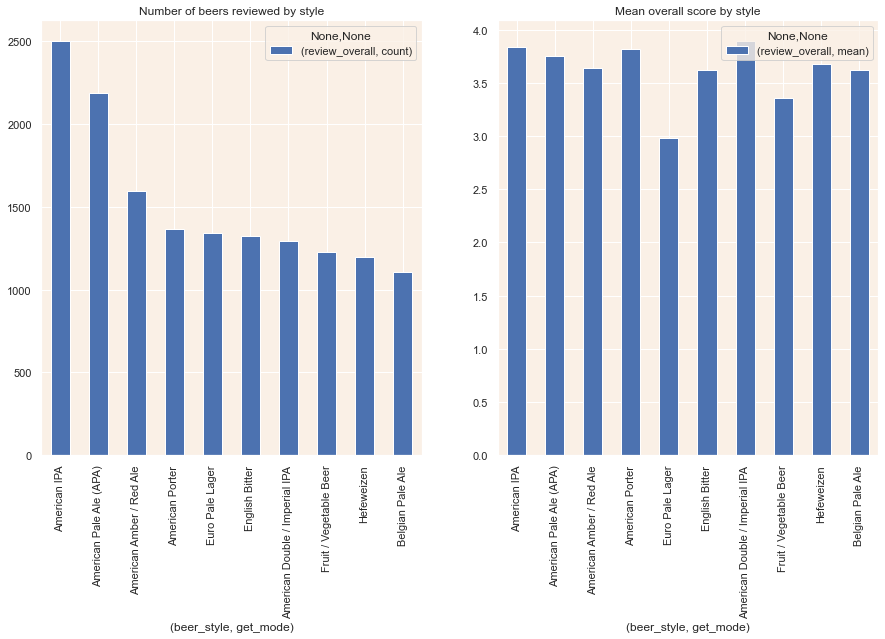

In [35]:
# visualise the 10 most popular styles
f, ax = plt.subplots(1,2, figsize=(15,8))
top_styles = df_styles.nlargest(10,columns = ('review_overall', 'count'), keep='all')

_ = top_styles.plot.bar(y=('review_overall', 'count'),ax=ax[0])
ax[0].set_title('Number of beers reviewed by style')

_ = top_styles.plot.bar(y=('review_overall', 'mean'),ax=ax[1])
ax[1].set_title('Mean overall score by style')

# ax.invert_yaxis()
plt.show()

The three most commonly reviewed styles of beer are  **American IPA**, **APA**, and **Red Ale**, I will dig deeper to choose one beer from each style.

In [36]:
# filter grouped df for reviews of top styles
top_styles = ['American IPA', 'American Pale Ale (APA)', 'American Amber / Red Ale']

df_ipa = df_reviews_agg[df_reviews_agg['beer_style','get_mode'] == 'American IPA'].copy()
df_apa = df_reviews_agg[df_reviews_agg['beer_style','get_mode'] == 'American Pale Ale (APA)'].copy()
df_red = df_reviews_agg[df_reviews_agg['beer_style','get_mode'] == 'American Amber / Red Ale'].copy()

df_red.head()


review_overall            \
                                                             count      mean   
brewery_name           beer_name        beer_beerid                            
10 Barrel Brewing Co.  Precursor        76436                    4  3.625000   
2 Brothers Brewery     Grizz            67637                    4  3.500000   
21st Amendment Brewery Amber Waves      60560                    3  3.666667   
                       North Star Red   2677                     7  3.571429   
                       Roasted American 68416                    1  3.500000   

                                                                   beer_style  
                                                                     get_mode  
brewery_name           beer_name        beer_beerid                            
10 Barrel Brewing Co.  Precursor        76436        American Amber / Red Ale  
2 Brothers Brewery     Grizz            67637        American Amber / Red Ale  
21st Amendment Brewery Amber Waves      60560        American Amber / Red Ale  
                       North Star Red   2677         American Amber / Red Ale  
                       Roasted American 68416        American Amber / Red Ale

In [37]:
# visualise the most common beers for each top style
top_15_reds = df_red['review_overall'].nlargest(15,'count', keep='all')
top_15_reds.reset_index(inplace=True)
top_15_reds.head()

,brewery_name,beer_name,beer_beerid,count,mean
0,Tröegs Brewing Company,Tröegs Nugget Nectar,15881,1879,4.391432
1,New Belgium Brewing,Fat Tire Amber Ale,607,1620,3.826235
2,Rogue Ales,Santa's Private Reserve Ale,1173,1112,3.809802
3,Bear Republic Brewing Co.,Red Rocket Ale,1655,1027,4.092502
4,Tröegs Brewing Company,Tröegs Hopback Amber Ale,6322,1020,4.179902


In [38]:
alt.Chart(top_15_reds).mark_circle(size=60, opacity=0.9).encode(
    x='mean',
    y='count',
    color='mean',
    tooltip=['brewery_name:N', 'beer_name:N', 'mean:Q']).properties(
    title='Red Ale Mean Review Score vs Reviews count').interactive()

alt.Chart(...)

In [39]:
top_15_apas = df_apa['review_overall'].nlargest(15,'count', keep='all')
top_15_apas.reset_index(inplace=True)
alt.Chart(top_15_apas).mark_circle(size=60, opacity=0.9).encode(
    x='mean',
    y='count',
    color='mean',
    tooltip=['brewery_name:N', 'beer_name:N', 'mean:Q']).properties(
    title='American Pale Ale Mean Review Score vs Reviews count').interactive()

alt.Chart(...)

In [40]:
top_15_ipas = df_ipa['review_overall'].nlargest(15,'count', keep='all')
top_15_ipas.reset_index(inplace=True)
alt.Chart(top_15_ipas).mark_circle(size=60, opacity=0.9).encode(
    x='mean',
    y='count',
    color='mean',
    tooltip=['brewery_name:N', 'beer_name:N', 'mean:Q']).properties(
    title='American IPA Mean Review Score vs Reviews count').interactive()

alt.Chart(...)

Although there are many ways to approach this problem, my recommendations provide 3 beers that have relatively high scores from 3 different popular styles. This provides a recipient with a range of different beers that have a good chance of being enjoyed.

**Answer:** 
- Tröegs Brewing Company, Tröegs Nugget Nectar (Red Ale)
- Three Floyds Brewing Co., Alpha King Pale Ale (APA)
- Ballast Point Brewing Company, Sculpin India Pale Ale (IPA)
---

#### Question 3

**Which of the factors (aroma, taste, appearance, palate) are most important in determining the overall quality of the beer?**

In [41]:
# For the purposes of this, which is essentially a feature selection problem,
# it is more robust to treat review scores as ordinal variables.

# First I want to create a custom ordered nominal data type for theses variables.
ratings_dtype = pd.CategoricalDtype(categories=sorted(df_beer['review_overall'].unique()), ordered=True)

# Cast to desired types (the time variable is ignored here since it is not relevant to this analysis)
df_beer = df_beer.astype({'review_overall':ratings_dtype, 'review_aroma':ratings_dtype, 'review_appearance':ratings_dtype,
                         'review_palate':ratings_dtype, 'review_taste':ratings_dtype})

I want to select features using a $\chi^2$ test as well as mutual information statistic. To validate the results I want to test how well the selected features predict the overall review score. Since the object is merely to validate the results, as opposed to optimising the model performance it will suffice to simply use a hold out validation (as opposed to k-fold) when making predictions.

In [42]:
df_beer.head(5)

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,2009-02-16 20:57:03,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,2009-03-01 13:44:57,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,2009-03-01 14:10:04,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,2009-02-15 19:12:25,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,2010-12-30 18:53:26,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883


Scores <function chi2 at 0x7fe438bd6200>
Feature - review_aroma: 134933.103124
Feature - review_taste: 239618.678301
Feature - review_appearance: 56793.425602
Feature - review_palate: 166135.634557


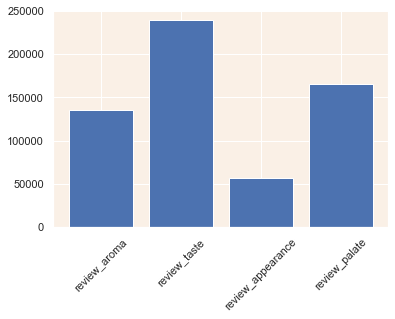

In [43]:
# We're using sklearn so import relevant functions
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

# define dataset
X, y = df_beer[['review_aroma','review_taste','review_appearance','review_palate']], df_beer['review_overall']

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# before the data can be fed into the feature selection it must undergo an encoding transformation.
# following functions adapted from: https://machinelearningmastery.com/feature-selection-with-categorical-data/

# prepare input data
def prepare_inputs(X_train, X_test):
    oe = OrdinalEncoder()
    oe.fit(X_train)
    X_train_enc = oe.transform(X_train)
    X_test_enc = oe.transform(X_test)
    return X_train_enc, X_test_enc
 
# prepare target
def prepare_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_test_enc
 
# feature selection
def select_features(X_train, y_train, X_test, score_func):
    fs = SelectKBest(score_func=score_func, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    
    return X_train_fs, X_test_fs, fs

def plot_scores(X_train,fs):
    print('Scores {}'.format(str(fs.score_func)))
    for i in range(len(fs.scores_)):
        print('Feature - {}: {:f}'.format(X_train.columns[i], fs.scores_[i]))

    plt.bar([X_train.columns[i] for i in range(len(fs.scores_))], fs.scores_)
    plt.xticks(rotation=45)
    plt.show()

X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)

X_train_fs_chi2, X_test_fs_chi2, fs_chi2 = select_features(X_train_enc, y_train_enc, X_test_enc, chi2)
plot_scores(X_train,fs_chi2)

Scores <function mutual_info_classif at 0x7fe438d5a050>
Feature - review_aroma: 0.244595
Feature - review_taste: 0.477536
Feature - review_appearance: 0.157859
Feature - review_palate: 0.342733


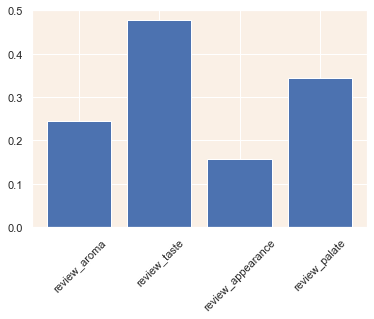

In [44]:
X_train_fs_mi, X_test_fs_mi, fs_mi = select_features(X_train_enc, y_train_enc, X_test_enc, mutual_info_classif)
plot_scores(X_train,fs_mi)

It seems there is a conclusive order with which to rank the importance of review factors in determining the overall score. Once more we could dig deeper but we have a resonable answe to the question.

**Answer:** Taste, followed by Palate.

#### Question 4

**If I typically enjoy a beer due to its aroma and appearance, which beer style should I try?**

Here I will need to aggregate similar to Q2 but witha focus on the aroma and appearance factors.

In [45]:
# revert review score dtypes back to floats for aggregation.

df_beer = df_beer.astype({'review_overall':'float64', 'review_aroma':'float64', 'review_appearance':'float64',
                         'review_palate':'float64', 'review_taste':'float64'})

group_cols = ['brewery_name','beer_name','beer_beerid']
summaries = {'review_aroma':'mean','review_appearance':'mean', 'beer_style':['count',get_mode]}

df_grouped = df_beer.groupby(group_cols)
df_reviews_agg = df_grouped.agg(summaries)
df_reviews_agg

review_aroma  \
                                                               mean   
brewery_name         beer_name             beer_beerid                
't Hofbrouwerijke    Blondelle             69815           4.500000   
                     Bosprotter            28810           3.833333   
                     Hof Korvatunturi      64095           4.000000   
                     Hofblues              33506           3.812500   
                     Hofdraak              33518           3.428571   
...                                                             ...   
Ørbæk Bryggeri       Nutty Nut Brown Ale   37387           2.500000   
                     Old Danish Braggot    47485           3.666667   
                     Pale Ale              37321           5.000000   
                     WeissBier Hyldeblomst 59088           4.000000   
Łódzkie Browary S.A. Porter &#321;ódzki    65334           4.000000   

                                                       review_appearance  \
                                                                    mean   
brewery_name         beer_name             beer_beerid                     
't Hofbrouwerijke    Blondelle             69815                3.500000   
                     Bosprotter            28810                3.666667   
                     Hof Korvatunturi      64095                3.750000   
                     Hofblues              33506                4.000000   
                     Hofdraak              33518                3.714286   
...                                                                  ...   
Ørbæk Bryggeri       Nutty Nut Brown Ale   37387                3.250000   
                     Old Danish Braggot    47485                3.833333   
                     Pale Ale              37321                4.000000   
                     WeissBier Hyldeblomst 59088                4.000000   
Łódzkie Browary S.A. Porter &#321;ódzki    65334                4.000000   

                                                       beer_style  \
                                                            count   
brewery_name         beer_name             beer_beerid              
't Hofbrouwerijke    Blondelle             69815                1   
                     Bosprotter            28810                9   
                     Hof Korvatunturi      64095                2   
                     Hofblues              33506               16   
                     Hofdraak              33518                7   
...                                                           ...   
Ørbæk Bryggeri       Nutty Nut Brown Ale   37387                2   
                     Old Danish Braggot    47485                3   
                     Pale Ale              37321                2   
                     WeissBier Hyldeblomst 59088                1   
Łódzkie Browary S.A. Porter &#321;ódzki    65334                1   

                                                                                 
                                                                       get_mode  
brewery_name         beer_name             beer_beerid                           
't Hofbrouwerijke    Blondelle             69815        Belgian Strong Pale Ale  
                     Bosprotter            28810                         Tripel  
                     Hof Korvatunturi      64095                        Old Ale  
                     Hofblues              33506               Belgian Dark Ale  
                     Hofdraak              33518               Belgian Dark Ale  
...                                                                         ...  
Ørbæk Bryggeri       Nutty Nut Brown Ale   37387              English Brown Ale  
                     Old Danish Braggot    47485                        Braggot  
                     Pale Ale              37321        American Pale Ale (APA)  
                     WeissBier Hyldeblomst 5

In [46]:
# aggregate further
summaries = {('review_aroma','mean'):'mean',('review_appearance','mean'):'mean'}

df_styles_grouped = df_reviews_agg.groupby(('beer_style','get_mode')).agg(summaries)
df_styles_grouped.index.name = 'Beer_Style'
df_styles_grouped = df_styles_grouped.droplevel(1, axis=1)
df_styles_grouped.reset_index(inplace=True)
df_styles_grouped.head()

,Beer_Style,review_aroma,review_appearance
0,Altbier,3.622797,3.839444
1,American Adjunct Lager,2.477589,2.820668
2,American Amber / Red Ale,3.501346,3.706834
3,American Amber / Red Lager,3.221171,3.507973
4,American Barleywine,3.931315,3.929204


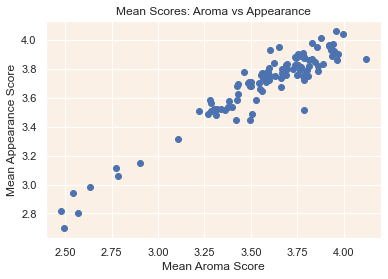

In [47]:
_ = plt.scatter(df_styles_grouped['review_aroma'],df_styles_grouped['review_appearance'])
_ = plt.xlabel('Mean Aroma Score')
_ = plt.ylabel('Mean Appearance Score')
_ = plt.title('Mean Scores: Aroma vs Appearance')
plt.show()

We can see there is a clear correlation but it is difficult to see exactly which style is optimal. I will colour code the display by mahalanobis distance (a distance metric for a given distribution) and display with a tooltip.

In [48]:
mean_aroma = df_styles_grouped['review_aroma'].mean()
mean_appearance = df_styles_grouped['review_appearance'].mean()

vals_vector = df_styles_grouped[['review_aroma','review_appearance']].values # extract np array from pd df for use in scipy
mean_vector = np.asarray([mean_aroma, mean_appearance]).reshape(1,2)
# Note: mean_vector.shape = (1,2) which allows for using as argument to scipy.spatial.distance.cdist()

from scipy import spatial

mahalanobis_dists = spatial.distance.cdist(vals_vector,mean_vector, metric='mahalanobis')[:,0]
# [:,0] because we only require the first column of the resulting matrix

df_styles_grouped['mahalanobis'] = mahalanobis_dists

In [49]:

alt.Chart(df_styles_grouped).mark_circle(size=60, opacity=0.8).encode(
    x='review_aroma',
    y='review_appearance',
    color = alt.Color('mahalanobis',
                      scale = alt.Scale(scheme='inferno')),
    tooltip=['Beer_Style:N']).properties(
    title='Mean Scores: Aroma vs Appearance').interactive()

alt.Chart(...)

There is potentially a better distance function to use to encode the colours here, perhaps one which takes the signed distance into account, however since I know subset of beer styles which i am chooseing all have positive distances form their means, this vis tells me that the additional reveiw_marks atributable to the Unblended Lambic's aroma _outwiegh_ those of the appearance of the Stouts.

**Answer:** Lambic - Unblended